# Sample training script with naive competitive self-play.

# Switch directory in Google drive so as to import CDA env.


In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

%cd "/root/ray_results/"
!ls -l
#!rm -rf PPO_continuousDoubleAuction-v0_*
!ls -l
!pwd

%cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
!ls -l

# !pip install -r requirements.txt

# !pip install tensorflow==2.2.0
# !pip install ray[rllib]==0.8.5
!pip install ray[rllib]==2.0.0

!pip show tensorflow
!pip show ray

!pip freeze > requirements.txt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/root/ray_results
total 37156
-rw-r--r-- 1 root root 37988389 Dec 11 09:27 folder.zip
drwx------ 2 root root     4096 Dec 11 07:19 PPO_continuousDoubleAuction-v0_2022-12-11_07-19-12_iq29ebq
drwx------ 2 root root     4096 Dec 11 07:20 PPO_continuousDoubleAuction-v0_2022-12-11_07-20-06s3kf5w12
drwx------ 2 root root     4096 Dec 11 07:45 PPO_continuousDoubleAuction-v0_2022-12-11_07-45-40ke_kfa7e
drwx------ 2 root root     4096 Dec 11 07:49 PPO_continuousDoubleAuction-v0_2022-12-11_07-49-17o1cs_tcm
drwx------ 2 root root     4096 Dec 11 07:51 PPO_continuousDoubleAuction-v0_2022-12-11_07-51-03brjicl6a
drwx------ 2 root root     4096 Dec 11 08:26 PPO_continuousDoubleAuction-v0_2022-12-11_08-25-21rwp5fnfl
drwx------ 2 root root     4096 Dec 11 08:27 PPO_continuousDoubleAuction-v0_2022-12-11_08-26-36imyt6t5o
drwx------ 2 root root     4096 Dec 11 08:33 PPO_contin

# Imports

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

from collections import defaultdict
from typing import Dict, Tuple

import ray
from ray import air, tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.policy import Policy
# from ray.rllib.agents.ppo import ppo

from ray.rllib.agents.ppo.ppo import PPOTrainer
import ray.rllib.algorithms.ppo as ppo

from ray.rllib.env import BaseEnv
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.evaluation import MultiAgentEpisode, Episode, RolloutWorker

# from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.rllib.algorithms.callbacks import DefaultCallbacks

from ray.tune.logger import pretty_print

In [3]:
import sys
if "../" not in sys.path:
    sys.path.append("../")
    
print(sys.path)

['/usr/local/lib/python3.8/dist-packages/ray/thirdparty_files', '/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '../']


In [4]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/gym-continuousDoubleAuction


In [5]:
from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv
from gym_continuousDoubleAuction.train.model.model_handler import CustomModel_1
from gym_continuousDoubleAuction.train.policy.policy_handler import make_RandomPolicy, gen_policy, set_agents_policies, create_train_policy_list
from gym_continuousDoubleAuction.train.weight.weight_handler import get_trained_policies_name, get_max_reward_ind, cp_weight
from gym_continuousDoubleAuction.train.storage.store_handler import storage
from gym_continuousDoubleAuction.train.callbk.callbk_handler import store_eps_hist_data
from gym_continuousDoubleAuction.train.logger.log_handler import create_dir, log_g_store, load_g_store
from gym_continuousDoubleAuction.train.plotter.plot_handler import plot_storage, plot_LOB_subplot, plot_sum_ord_imb, plot_mid_prices
from gym_continuousDoubleAuction.train.helper.helper import ord_imb, sum_ord_imb, mid_price

# tf = try_import_tf()

# Global


In [6]:
# CDA_env args
num_agents = 8
num_trained_agent = 2 # 
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 100000
max_step = 5120 #4096 # per episode, -1 in arg. (~7.2s/1000steps/iter)
is_render = False 

In [7]:
# RLlib config 
train_policy_list = create_train_policy_list(num_trained_agent, "policy_")
#num_cpus = 0.25                                
num_gpus = 0 #0.75                       
num_cpus_per_worker = 0.25                                
num_gpus_per_worker = 0
num_workers = 2
num_envs_per_worker = 1
batch_mode = "complete_episodes" 
rollout_fragment_length = 128
train_batch_size = max_step
sgd_minibatch_size = 256
num_iters = 32

train_policy_list =  ['policy_0', 'policy_1']


In [8]:
log_base_dir = "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/results/"
# log_base_dir = "/home/ray/gym-continuousDoubleAuction/results/"
log_dir = log_base_dir + "ray_results/"

# Chkpt & restore
local_dir = log_base_dir + "chkpt/"
chkpt_freq = 10
chkpt = 320
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = False # True / False

# log & load 
log_g_store_dir = log_base_dir + "log_g_store/"
print(f'log_base_dir:{log_base_dir}')
print(f'log_g_store_dir:{log_g_store_dir}')
create_dir(log_base_dir)    
create_dir(log_g_store_dir)    

log_base_dir:/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/results/
log_g_store_dir:/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/results/log_g_store/
Folder creation failed or folder already exists: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/results/
Folder creation failed or folder already exists: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/results/log_g_store/


In [9]:
# def get_config():
#     config = ppo.DEFAULT_CONFIG.copy()
#     config["multiagent"] = {
#         "policies_to_train": train_policy_list,
#         "policies": policies,
#         "policy_mapping_fn": policy_mapper,
#     }    
#     #config["num_cpus"] = num_cpus     # trainer, applicable only when using tune.
#     config["num_gpus"] = num_gpus     # trainer
#     config["num_cpus_per_worker"] = num_cpus_per_worker                                
#     config["num_gpus_per_worker"] = num_gpus_per_worker                      
#     config["num_workers"] = num_workers
#     config["num_envs_per_worker"] = num_envs_per_worker  
    
#     config["remote_worker_envs"] = True  

#     config["batch_mode"] = batch_mode       # "complete_episodes" / "truncate_episodes"
#     config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
#                                                   # Samples batches will be concatenated together to a batch of this size,
#                                                   # which is then passed to SGD.
#     config["rollout_fragment_length"] = rollout_fragment_length # replaced "sample_batch_size",
#     config["sgd_minibatch_size"] = sgd_minibatch_size 
#     config["log_level"] = "WARN" # WARN/INFO/DEBUG 
#     config["callbacks"] = MyCallbacks
#     config["output"] = log_dir
#     config["disable_env_checking"]=True

#     return config

In [10]:
# from ray.tune.registry import register_env

# def env_creator(env_config):
#     return MyEnv(...)  # return an env instance

# register_env("my_env", env_creator)
# algo = ppo.PPO(env="my_env")

In [11]:
# class MultiEnv(gym.Env):
#     def __init__(self, env_config):
#         # pick actual env based on worker and env indexes
#         self.env = gym.make(
#             choose_env_for(env_config.worker_index, env_config.vector_index))
#         self.action_space = self.env.action_space
#         self.observation_space = self.env.observation_space
#     def reset(self):
#         return self.env.reset()
#     def step(self, action):
#         return self.env.step(action)

# register_env("multienv", lambda config: MultiEnv(config))

In [12]:
# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(
    num_of_traders, 
    init_cash, 
    tick_size, 
    tape_display_length, 
    max_step, 
    is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# def env_creator(env_config):
#     return continuousDoubleAuctionEnv(
#         num_of_traders, 
#         init_cash, 
#         tick_size, 
#         tape_display_length,
#         max_step-1, 
#         is_render)

# register CDA env with RLlib 
register_env(
    "continuousDoubleAuction-v0", 
    lambda _: continuousDoubleAuctionEnv(
        num_of_traders, 
        init_cash, 
        tick_size, 
        tape_display_length,
        max_step-1, 
        is_render))
# register_env(
#     "continuousDoubleAuction-v0", 
#     env_creator)
# register_env("continuousDoubleAuction-v0", lambda config: continuousDoubleAuctionEnv(config))

# register custom model (neural network)
ModelCatalog.register_custom_model(
    "model_disc", 
    CustomModel_1) 

# start ray
ray.shutdown()
assert not ray.is_initialized()
# ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 
ray.init()
assert ray.is_initialized()

# Global storage, a ray actor that run on it's own process & it needs to be declared after ray.init().
# g_store = storage.options(name="g_store", detached=True).remote(num_agents)
# g_store = storage.options(name="g_store", lifetime="detached").remote(num_agents)
g_store = storage.options(name="g_store").remote(num_agents)

2022-12-11 09:33:34,263	INFO worker.py:1518 -- Started a local Ray instance.


# Policies

In [13]:
# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i, obs_space, act_space) for i in range(num_policies)}
set_agents_policies(policies, obs_space, act_space, num_agents, num_trained_agent)
policy_ids = list(policies.keys())

# def policy_mapper(agent_id):
#     """
#     Required in RLlib config.
#     """
#     for i in range(num_agents):
#         if agent_id == i:            
#             return "policy_{}".format(i)               

def policy_mapper(agent_id, episode, worker, **kwargs):
    """
    Required in RLlib config.
    """
    for i in range(num_agents):
        if agent_id == i:            
            return "policy_{}".format(i)    

policies: {'policy_0': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_1': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_2': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_3': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_4': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12)), {}), 'policy_5': (None, Box(-inf, inf, (4, 10), float32), Tuple(Discrete(3), Discrete(4), Box(-1.0, 1.0, (1,), float32), Box(0.0, 1.0, (1,), float32), Discrete(12))

# Call back.

In [14]:
class MyCallbacks(DefaultCallbacks):
    # def on_episode_start(
    #     self, 
    #     worker: RolloutWorker, 
    #     base_env: BaseEnv,
    #     policies: Dict[str, Policy],
    #     episode: MultiAgentEpisode, 
    #     **kwargs
    # ):
    def on_episode_start(
        self, 
        *,
        worker: RolloutWorker, 
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode, 
        **kwargs
    ):
        """
        info["episode"] is a MultiAgentEpisode object.

        user_data dicts at 100000 items max, will auto replace old with new item at 1st index.
        hist_data dicts at 100 items max, will auto replace old with new item at 1st index.
        """
        #print("on_episode_start {}, _agent_to_policy {}".format(episode.episode_id, episode._agent_to_policy))

        prefix = "agt_"
        for i in range(num_agents):
            episode.user_data[prefix + str(i) + "_obs"] = []
            episode.user_data[prefix + str(i) + "_act"] = []
            episode.user_data[prefix + str(i) + "_reward"] = []
            episode.user_data[prefix + str(i) + "_NAV"] = []
            episode.user_data[prefix + str(i) + "_num_trades"] = []

            episode.hist_data[prefix + str(i) + "_reward"] = []
            episode.hist_data[prefix + str(i) + "_NAV"] = []
            episode.hist_data[prefix + str(i) + "_num_trades"] = []

#     def on_episode_step(
#         self, 
#         *,
#         worker: RolloutWorker, 
#         base_env: BaseEnv,
#         episode: MultiAgentEpisode, 
#         **kwargs):
    def on_episode_step(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs
    ):
        """
        pole_angle = abs(episode.last_observation_for()[2])
        raw_angle = abs(episode.last_raw_obs_for()[2])
        assert pole_angle == raw_angle
        episode.user_data["pole_angles"].append(pole_angle)
        """

        prefix = "agt_"
        for i in range(num_agents):
            obs = episode.last_raw_obs_for(i)
            #obs = episode.last_observation_for(i)
            act = episode.last_action_for(i)
            reward = episode.last_info_for(i).get("reward")
            NAV = episode.last_info_for(i).get("NAV")
            NAV = None if NAV is None else float(NAV)
            num_trades = episode.last_info_for(i).get("num_trades")
        
            if reward is None:      # goto next agent.
                continue

            episode.user_data[prefix + str(i) + "_obs"].append(obs)    
            episode.user_data[prefix + str(i) + "_act"].append(act)    
            episode.user_data[prefix + str(i) + "_reward"].append(reward)    
            episode.user_data[prefix + str(i) + "_NAV"].append(NAV)    
            episode.user_data[prefix + str(i) + "_num_trades"].append(num_trades)          

#     def on_episode_end(
#         self, 
#         worker: RolloutWorker, 
#         base_env: BaseEnv,
#         policies: Dict[str, Policy], 
#         episode: MultiAgentEpisode,
#         **kwargs):
    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs
    ):
        #print("on_episode_end {}, episode.agent_rewards {}".format(episode.episode_id, episode.agent_rewards))
        """
        arg: {"env": .., "episode": ...}
        """

#         g_store = ray.util.get_actor("g_store")
        g_store = ray.get_actor("g_store")

        prefix = "agt_"
        for agt_id in range(num_agents):
            obs_key = prefix + str(agt_id) + "_obs"
            act_key = prefix + str(agt_id) + "_act"
            reward_key = prefix + str(agt_id) + "_reward"
            NAV_key = prefix + str(agt_id) + "_NAV"
            num_trades_key = prefix + str(agt_id) + "_num_trades"      

            # store into episode.hist_data
            store_eps_hist_data(episode, reward_key)
            store_eps_hist_data(episode, NAV_key)
            store_eps_hist_data(episode, num_trades_key)

            # store step data
            obs = episode.user_data[obs_key]
            act = episode.user_data[act_key]
            reward = episode.user_data[reward_key]
            NAV = episode.user_data[NAV_key]
            num_trades = episode.user_data[num_trades_key]
            ray.get(g_store.store_agt_step.remote(agt_id, obs, act, reward, NAV, num_trades))       
        
            # Store episode data.   
            eps_reward = np.sum(reward)
            eps_NAV = np.mean(NAV)
            eps_num_trades = np.sum(num_trades)
            ray.get(g_store.store_agt_eps.remote(agt_id, eps_reward, eps_NAV, eps_num_trades))

        ray.get(g_store.inc_eps_counter.remote())  
        print("eps sampled so far {}".format(ray.get(g_store.get_eps_counter.remote())))

#     def on_sample_end(
#         self, 
#         worker: RolloutWorker, 
#         samples: SampleBatch,
#         **kwargs
#     ):
    def on_sample_end(
        self, 
        *, 
        worker: RolloutWorker, 
        samples: SampleBatch, 
        **kwargs
    ):
        """
        arg: {"samples": .., "worker": ...}

        Notes:
            https://github.com/ray-project/ray/blob/master/rllib/policy/sample_batch.py        
        """
        #print("on_sample_end returned sample batch of size {}".format(samples.count))

        """
        MultiAgentBatch_obj = info["samples"]
        MultiAgentBatch_policy_batches = MultiAgentBatch_obj.policy_batches
        MultiAgentBatch_count = MultiAgentBatch_obj.count

        access_sample_batches(MultiAgentBatch_policy_batches)
        print("info['samples'].policy_batches = {}".format(info["samples"].policy_batches))
        print("info['worker'] = {}".format(info["worker"])) # RolloutWorker object
        """

    def on_train_result(
        self, 
        *, 
        trainer, 
        result: dict, 
        **kwargs
    ):
#     def on_train_result(self, trainer, result: dict, **kwargs):
        """
        info["trainer"] is the trainer object.

        info["result"] contains a bunch of info such as episodic rewards for 
        each policy in info["result"][hist_stats] dictionary.
        """
        #print("trainer.train() result: {} -> {} episodes".format(trainer, result["episodes_this_iter"]))
        # you can mutate the result dict to add new fields to return
        result["callback_ok"] = True
        #print("on_train_result result", result)
    
        train_policies_name = get_trained_policies_name(policies, num_trained_agent)    
        max_reward_ind = get_max_reward_ind(result, train_policies_name)
        max_reward_policy_name = train_policies_name[max_reward_ind]
        cp_weight(trainer, train_policies_name, max_reward_policy_name)    

#         g_store = ray.util.get_actor("g_store")   
        g_store = ray.get_actor("g_store")      

        prefix = "policy_policy_"
        suffix = "_reward"
        hist_stats = result["hist_stats"]
        eps_this_iter = result["episodes_this_iter"]
        for agt_id in range(num_agents):
            key = prefix + str(agt_id) + suffix
            for i in range(eps_this_iter):
                ray.get(g_store.store_agt_train.remote(agt_id, hist_stats[key][i]))

        #print("on_train_result info['result'] {}".format(info["result"]))     

#     def on_postprocess_trajectory(
#         self, 
#         worker: RolloutWorker, 
#         episode: MultiAgentEpisode,
#         agent_id: str, 
#         policy_id: str, 
#         policies: Dict[str, Policy],
#         postprocessed_batch: SampleBatch,
#         original_batches: Dict[str, SampleBatch], 
#         **kwargs
#     ):
    def on_postprocess_trajectory(
        self,
        *,
        worker: RolloutWorker,
        episode: Episode,
        agent_id: str,
        policy_id: str,
        policies: Dict[str, Policy],
        postprocessed_batch: SampleBatch,
        original_batches: Dict[str, Tuple[Policy, SampleBatch]],
        **kwargs
    ):
        #print("postprocessed {}, {}, {}, {} steps".format(episode, agent_id, policy_id, postprocessed_batch.count))
        """
        if "num_batches" not in episode.custom_metrics:
            episode.custom_metrics["num_batches"] = 0
        episode.custom_metrics["num_batches"] += 1        

        arg: {"agent_id": ..., "episode": ...,
              "pre_batch": (before processing),
              "post_batch": (after processing),
              "all_pre_batches": (other agent ids)}

        # https://github.com/ray-project/ray/blob/ee8c9ff7320ec6a2d7d097cd5532005c6aeb216e/rllib/policy/sample_batch.py
        Dictionaries in a sample_obj, k:
            t
            eps_id
            agent_index
            obs
            actions
            rewards
            prev_actions
            prev_rewards
            dones
            infos
            new_obs
            action_prob
            action_logp
            vf_preds
            behaviour_logits
            unroll_id       
        """

        """
        policy_obj = info["pre_batch"][0]
        sample_obj = info["pre_batch"][1]    
        agt_id = info["agent_id"]
        eps_id = info["episode"].episode_id
        """        

# RLlib config

In [15]:
def get_config():
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {
        "policies_to_train": train_policy_list,
        "policies": policies,
        "policy_mapping_fn": policy_mapper,
    }    
    #config["num_cpus"] = num_cpus     # trainer, applicable only when using tune.
    config["num_gpus"] = num_gpus     # trainer
    config["num_cpus_per_worker"] = num_cpus_per_worker                                
    config["num_gpus_per_worker"] = num_gpus_per_worker                      
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    
    # config["remote_worker_envs"] = True # Step envs in parallel if True.

    config["batch_mode"] = batch_mode       # "complete_episodes" / "truncate_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                                  # Samples batches will be concatenated together to a batch of this size,
                                                  # which is then passed to SGD.
    config["rollout_fragment_length"] = rollout_fragment_length # replaced "sample_batch_size",
    config["sgd_minibatch_size"] = sgd_minibatch_size 
    config["log_level"] = "WARN" # WARN/INFO/DEBUG 
    config["callbacks"] = MyCallbacks
    config["output"] = log_dir
    config["disable_env_checking"]=True

    # # Auto-wrap the custom(!) model with an LSTM.
    # config["use_lstm"] = True,
    # # To further customize the LSTM auto-wrapper.
    # config["lstm_cell_size"] = 8,
    # model = {
    #     # Auto-wrap the custom(!) model with an LSTM.
    #     "use_lstm": True,
    #     # To further customize the LSTM auto-wrapper.
    #     "lstm_cell_size": 64,
    #     # Specify our custom model from above.
    #     "custom_model": "model_disc",
    #     # Extra kwargs to be passed to your model's c'tor.
    #     "custom_model_config": {},
    # }
    # config["training"] = model 

    # config["framework"] = "tf2" 
    # config["eager_tracing"] = False

    return config

# Train


In [16]:
def go_train(config):    
#     trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    trainer = ppo.PPO(config=config, env="continuousDoubleAuction-v0")
#     trainer = ppo.PPO(env="continuousDoubleAuction-v0")

    if is_restore == True:
        trainer.restore(restore_path)

    # g_store = ray.util.get_actor("g_store")    
    g_store = ray.get_actor("g_store")    
    results = []
    file_IDs = []
    for i in range(num_iters):
        result = trainer.train()      
        results.append(result) 
        # print(pretty_print(result)) # includes result["custom_metrics"]
        print(pretty_print(result["custom_metrics"]))

        print("training loop = {} of {}".format(i + 1, num_iters))            
        # print("eps sampled so far {}".format(ray.get(g_store.get_eps_counter.remote())))
        
        file_ID = result['experiment_id'] + '_' + str(i)
        print(f"file_ID: {file_ID}")
        file_IDs.append(file_ID)


        log_g_store(log_g_store_dir, num_agents, file_ID)
        ray.get(g_store.reset.remote(num_agents))


        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)

    return results, file_IDs


# run everything
results, file_IDs = go_train(get_config())            

2022-12-11 09:33:36,223	INFO algorithm.py:1871 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-12-11 09:33:36,235	INFO algorithm.py:351 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.8/dist-packages/ray/_private/ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(


(storage pid=8329) create_storage


(pid=8333) /usr/local/lib/python3.8/dist-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
(pid=8333)   import imp
(pid=8355) /usr/local/lib/python3.8/dist-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
(pid=8355)   import imp
2022-12-11 09:34:22,005	INFO trainable.py:160 -- Trainable.setup took 45.790 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-12-11 09:34:22,015	WARNING util.py:65 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=8355) /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/envs/exchg/action_helper.py:176: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
(RolloutWorker pid=8

(RolloutWorker pid=8355) eps sampled so far 1
(RolloutWorker pid=8333) eps sampled so far 2


2022-12-11 09:36:56,022	WARNING deprecation.py:47 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!


agt_0_NAV_max: 98971.41875
agt_0_NAV_mean: 97891.082421875
agt_0_NAV_min: 96810.74609375
agt_0_num_trades_max: 942.9736328125
agt_0_num_trades_mean: 898.11953125
agt_0_num_trades_min: 853.2654296875
agt_0_reward_max: -6.655078125
agt_0_reward_mean: -9.866015625
agt_0_reward_min: -13.076953125
agt_1_NAV_max: 100988.659765625
agt_1_NAV_mean: 99838.5634765625
agt_1_NAV_min: 98688.4671875
agt_1_num_trades_max: 900.8080078125
agt_1_num_trades_mean: 893.0599609375
agt_1_num_trades_min: 885.3119140625
agt_1_reward_max: -4.204296875
agt_1_reward_mean: -5.0498046875
agt_1_reward_min: -5.8953125
agt_2_NAV_max: 100784.6828125
agt_2_NAV_mean: 98463.204296875
agt_2_NAV_min: 96141.72578125
agt_2_num_trades_max: 1112.0736328125
agt_2_num_trades_mean: 1051.35546875
agt_2_num_trades_min: 990.6373046875
agt_2_reward_max: 16.883203125
agt_2_reward_mean: 8.6416015625
agt_2_reward_min: 0.4
agt_3_NAV_max: 99857.43046875
agt_3_NAV_mean: 97602.2001953125
agt_3_NAV_min: 95346.969921875
agt_3_num_trades_max: 91

In [17]:
# Zip ray_results folder for ease of download.
!zip -r ~/ray_results/folder.zip ~/ray_results

updating: root/ray_results/ (stored 0%)
updating: root/ray_results/PPO_continuousDoubleAuction-v0_2022-12-11_07-49-17o1cs_tcm/ (stored 0%)
updating: root/ray_results/PPO_continuousDoubleAuction-v0_2022-12-11_07-49-17o1cs_tcm/params.json (deflated 69%)
updating: root/ray_results/PPO_continuousDoubleAuction-v0_2022-12-11_07-49-17o1cs_tcm/events.out.tfevents.1670744957.9e3400a434c7 (deflated 5%)
updating: root/ray_results/PPO_continuousDoubleAuction-v0_2022-12-11_07-49-17o1cs_tcm/params.pkl (deflated 58%)
updating: root/ray_results/PPO_continuousDoubleAuction-v0_2022-12-11_07-49-17o1cs_tcm/result.json (stored 0%)
updating: root/ray_results/PPO_continuousDoubleAuction-v0_2022-12-11_07-19-12_iq29ebq/ (stored 0%)
updating: root/ray_results/PPO_continuousDoubleAuction-v0_2022-12-11_07-19-12_iq29ebq/params.json (deflated 69%)
updating: root/ray_results/PPO_continuousDoubleAuction-v0_2022-12-11_07-19-12_iq29ebq/params.pkl (deflated 58%)
updating: root/ray_results/PPO_continuousDoubleAuction-v0_

# Plot all steps from last episode.

Agt_0, 1, 2 are trained agents (with PPO) while the rest are random agents.

In [18]:
file_IDs

['f3a6b9f3cce848fe92794f060e68a4d0_0',
 'f3a6b9f3cce848fe92794f060e68a4d0_1',
 'f3a6b9f3cce848fe92794f060e68a4d0_2',
 'f3a6b9f3cce848fe92794f060e68a4d0_3',
 'f3a6b9f3cce848fe92794f060e68a4d0_4',
 'f3a6b9f3cce848fe92794f060e68a4d0_5',
 'f3a6b9f3cce848fe92794f060e68a4d0_6',
 'f3a6b9f3cce848fe92794f060e68a4d0_7',
 'f3a6b9f3cce848fe92794f060e68a4d0_8',
 'f3a6b9f3cce848fe92794f060e68a4d0_9',
 'f3a6b9f3cce848fe92794f060e68a4d0_10',
 'f3a6b9f3cce848fe92794f060e68a4d0_11',
 'f3a6b9f3cce848fe92794f060e68a4d0_12',
 'f3a6b9f3cce848fe92794f060e68a4d0_13',
 'f3a6b9f3cce848fe92794f060e68a4d0_14',
 'f3a6b9f3cce848fe92794f060e68a4d0_15',
 'f3a6b9f3cce848fe92794f060e68a4d0_16',
 'f3a6b9f3cce848fe92794f060e68a4d0_17',
 'f3a6b9f3cce848fe92794f060e68a4d0_18',
 'f3a6b9f3cce848fe92794f060e68a4d0_19',
 'f3a6b9f3cce848fe92794f060e68a4d0_20',
 'f3a6b9f3cce848fe92794f060e68a4d0_21',
 'f3a6b9f3cce848fe92794f060e68a4d0_22',
 'f3a6b9f3cce848fe92794f060e68a4d0_23',
 'f3a6b9f3cce848fe92794f060e68a4d0_24',
 'f3a6b9f3

# Plot steps from last episode.

In [19]:
load_g_store(log_g_store_dir, num_agents, file_IDs[-1])

702408dcd6d7496bac063074b44a3f87_0.gzip
702408dcd6d7496bac063074b44a3f87_1.gzip
d0a35dd40e554cb98eed180b87257d05_0.gzip
d0a35dd40e554cb98eed180b87257d05_1.gzip
2e197e3e90c14ce5986eadfa78a9a256_0.gzip
2e197e3e90c14ce5986eadfa78a9a256_1.gzip
6573c4cdb5004ad7b75fa4f3c603a2e8_0.gzip
6573c4cdb5004ad7b75fa4f3c603a2e8_1.gzip
4870d5eb9ff5472d847565e4c793a3fd_0.gzip
0bb17b1271054caea68d1612a9700004_0.gzip
0bb17b1271054caea68d1612a9700004_1.gzip
0bb17b1271054caea68d1612a9700004_2.gzip
5f3f82a4dffc4d78bfcd6c19cb52a937_0.gzip
5f3f82a4dffc4d78bfcd6c19cb52a937_1.gzip
5f3f82a4dffc4d78bfcd6c19cb52a937_2.gzip
5f3f82a4dffc4d78bfcd6c19cb52a937_3.gzip
5f3f82a4dffc4d78bfcd6c19cb52a937_4.gzip
5f3f82a4dffc4d78bfcd6c19cb52a937_5.gzip
5f3f82a4dffc4d78bfcd6c19cb52a937_6.gzip
654e8207b7084f8fa934cf1ccad1ea36_0.gzip
654e8207b7084f8fa934cf1ccad1ea36_1.gzip
654e8207b7084f8fa934cf1ccad1ea36_2.gzip
654e8207b7084f8fa934cf1ccad1ea36_3.gzip
654e8207b7084f8fa934cf1ccad1ea36_4.gzip
654e8207b7084f8fa934cf1ccad1ea36_5.gzip


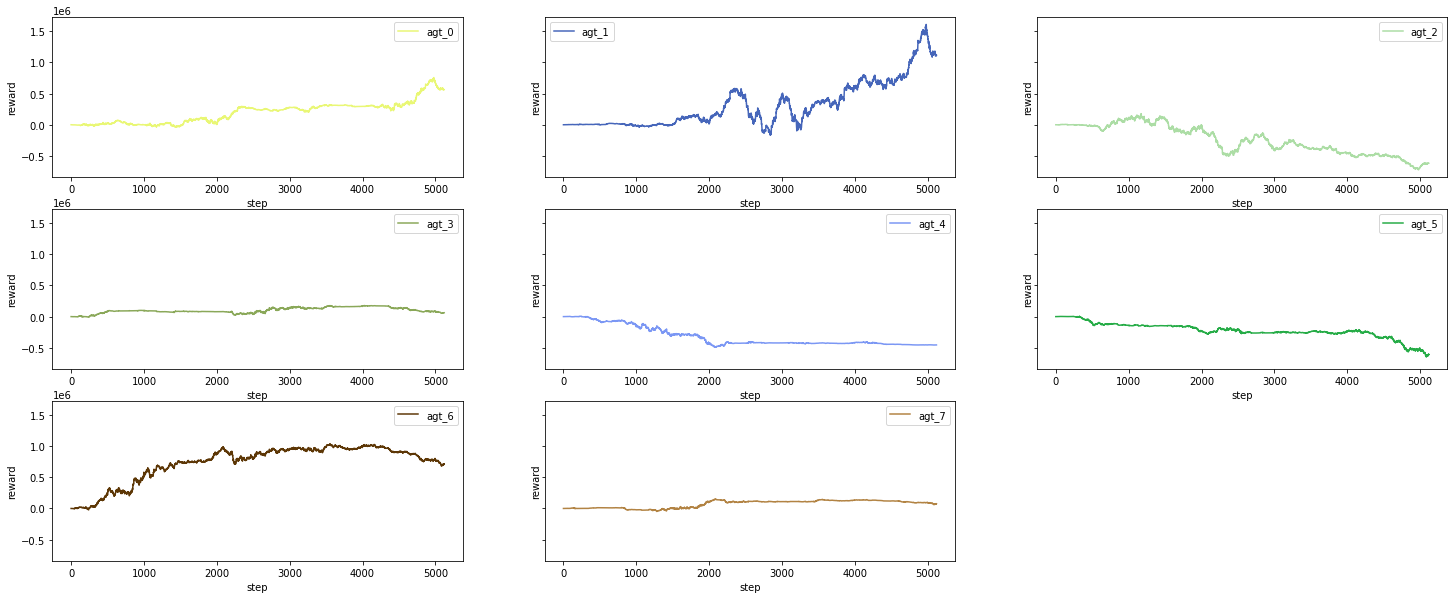

In [20]:
plot_storage(num_agents, init_cash)

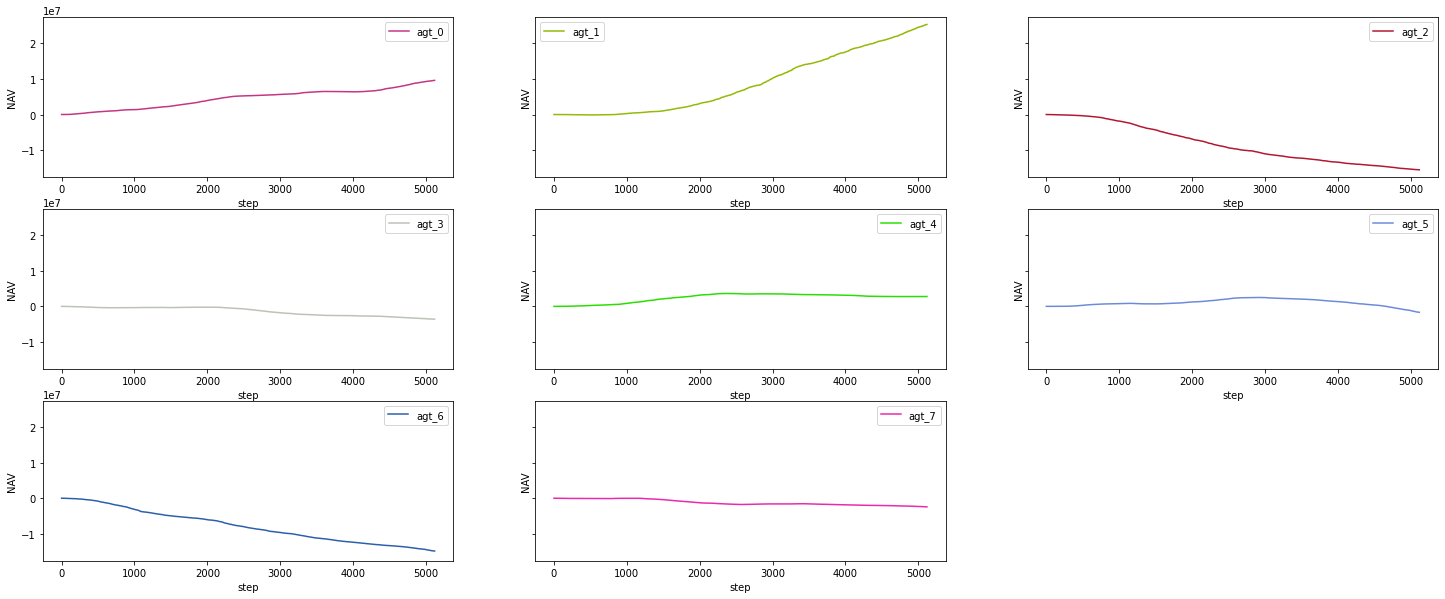

In [21]:
plot_storage(num_agents, init_cash, "step", "NAV")

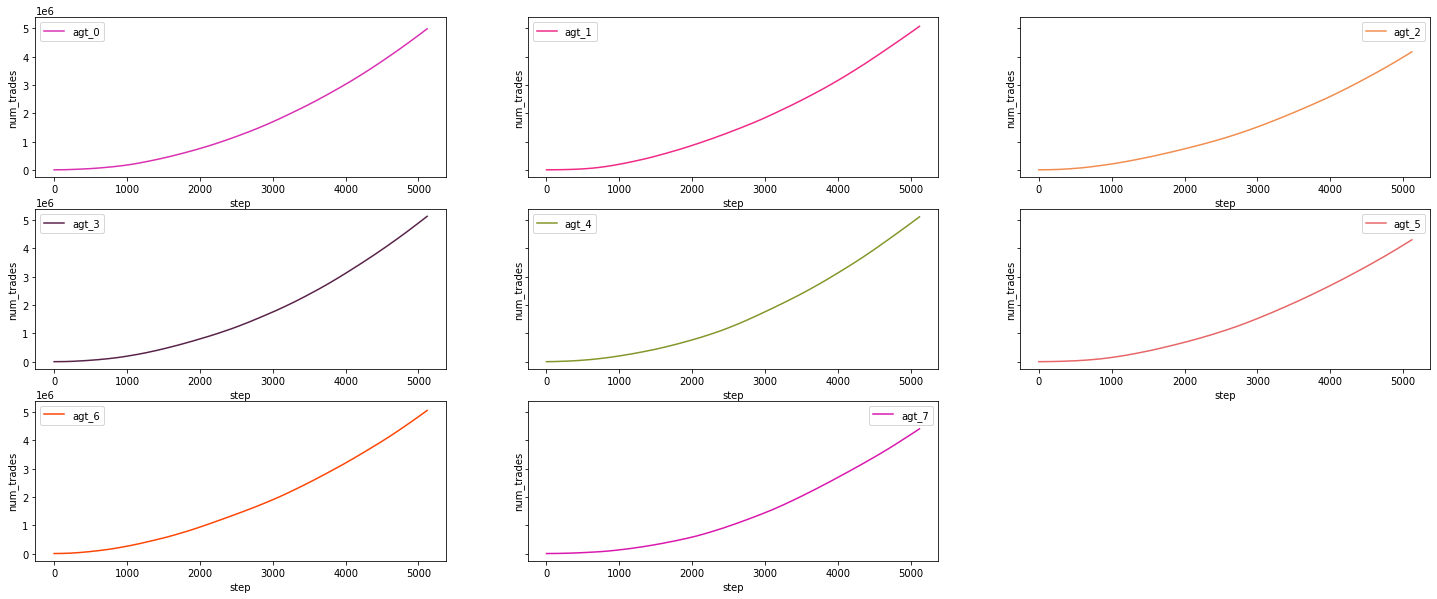

In [22]:
plot_storage(num_agents, init_cash, "step", "num_trades")

# LOB from last episode.

In [23]:
g_store = ray.get_actor("g_store")          

depth = 10
bid_size, bid_price, ask_size, ask_price = ray.get(g_store.get_obs_from_agt.remote(0, depth))

# LOB order imbalance

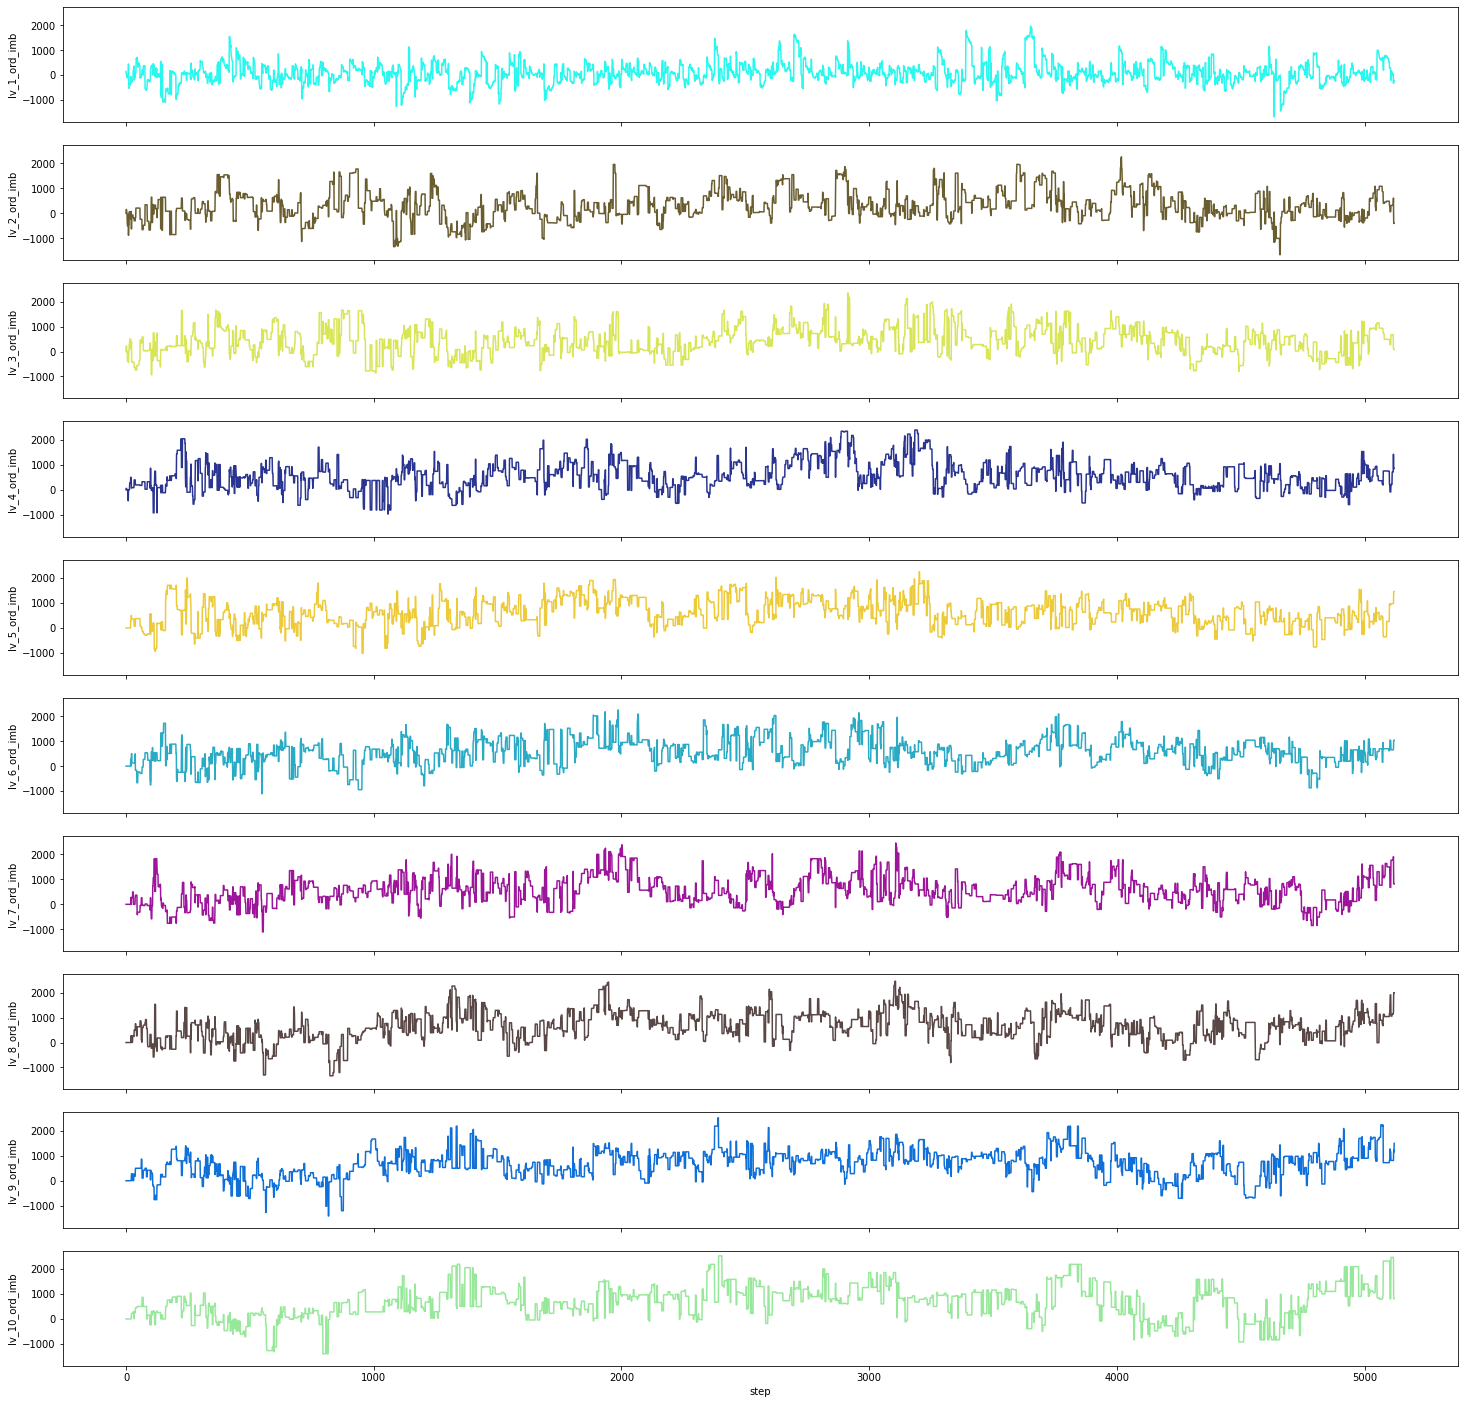

In [24]:
ord_imb_store = ord_imb(bid_size, ask_size)
plot_LOB_subplot(ord_imb_store, depth, '_ord_imb') 

# LOB sum of order imbalance

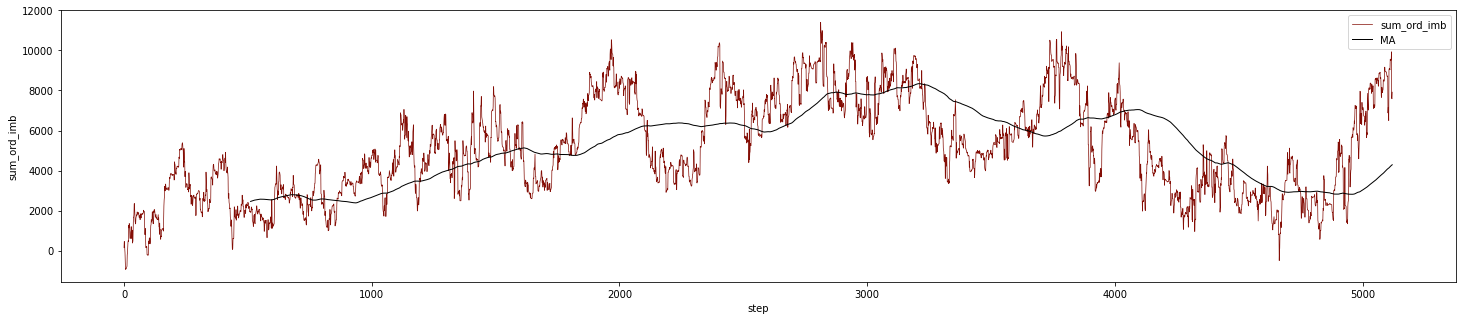

In [25]:
ord_imb_store = np.asarray(ord_imb_store)
sum_ord_imb_store = sum_ord_imb(ord_imb_store)
plot_sum_ord_imb(sum_ord_imb_store, "sum_ord_imb")

# LOB mid price (subplot)

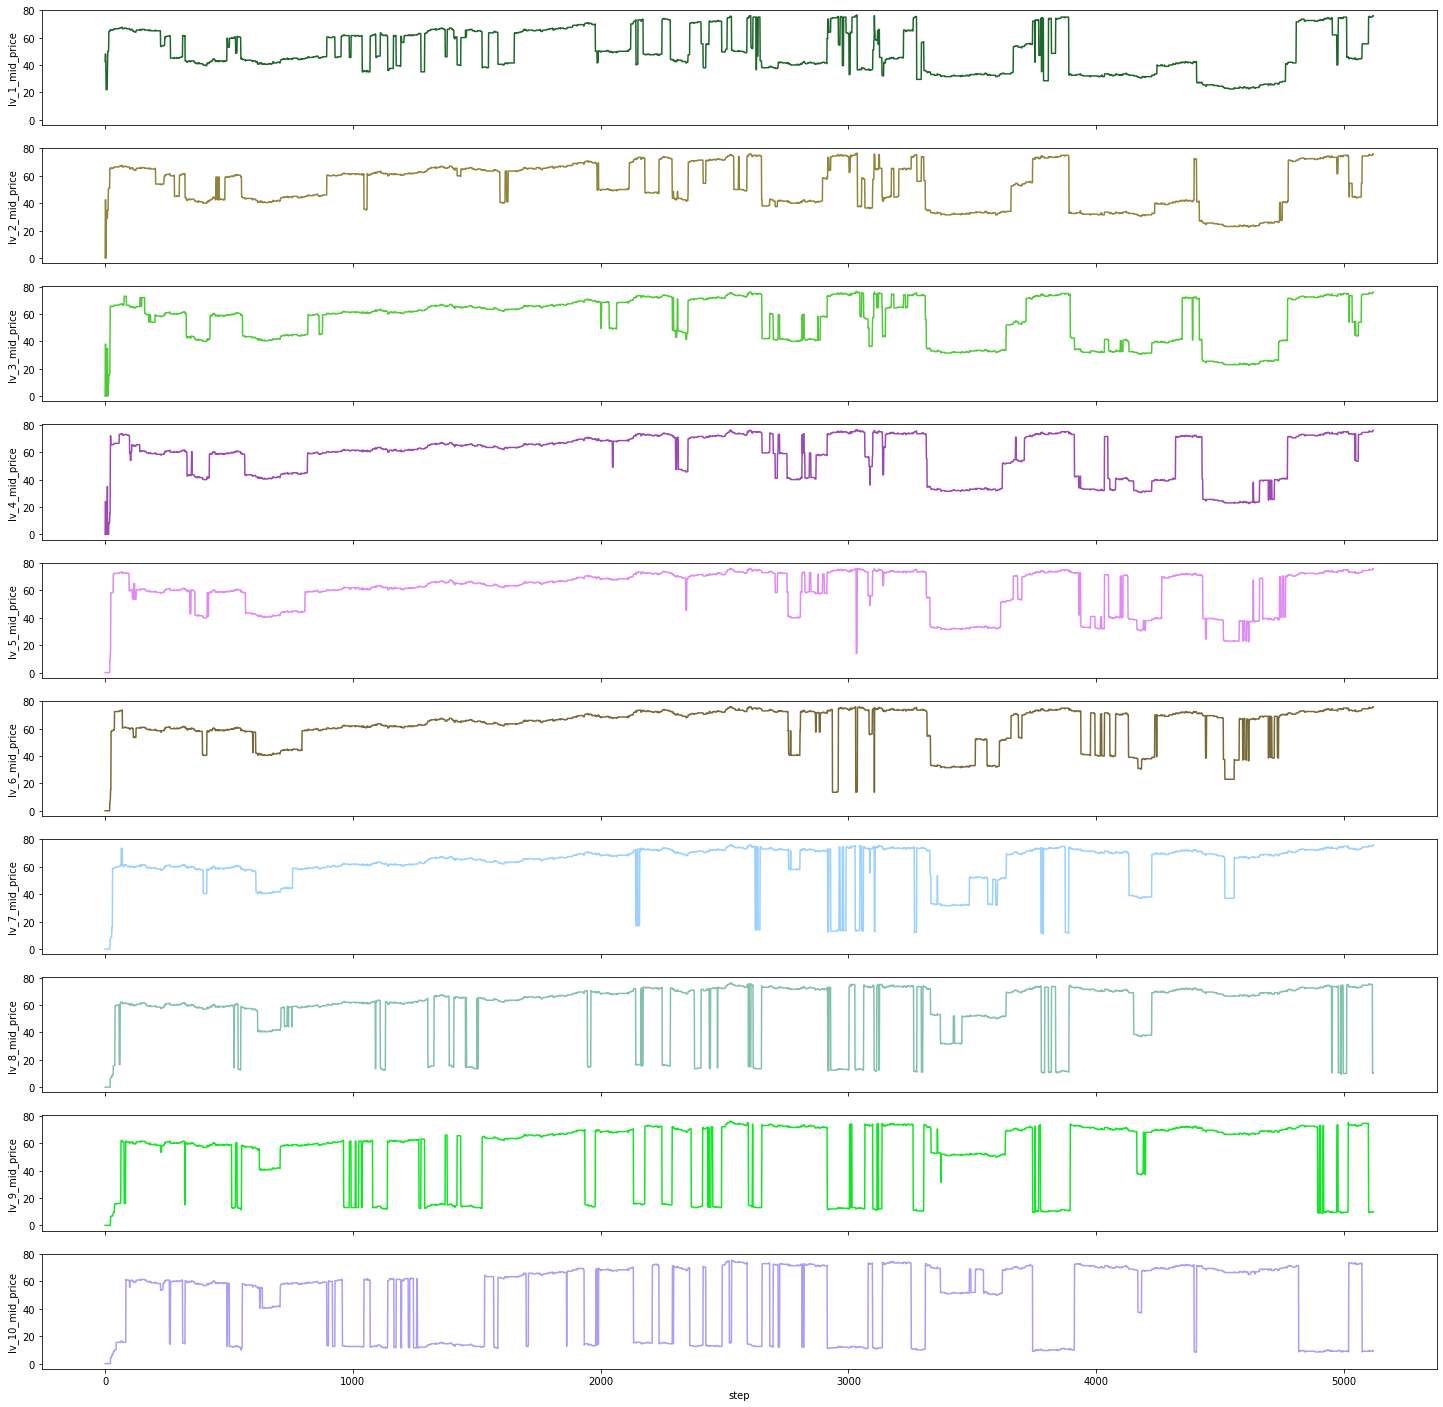

In [26]:
mid_price_store = mid_price(bid_price, ask_price)
plot_LOB_subplot(mid_price_store, depth, '_mid_price')    

# LOB mid prices 

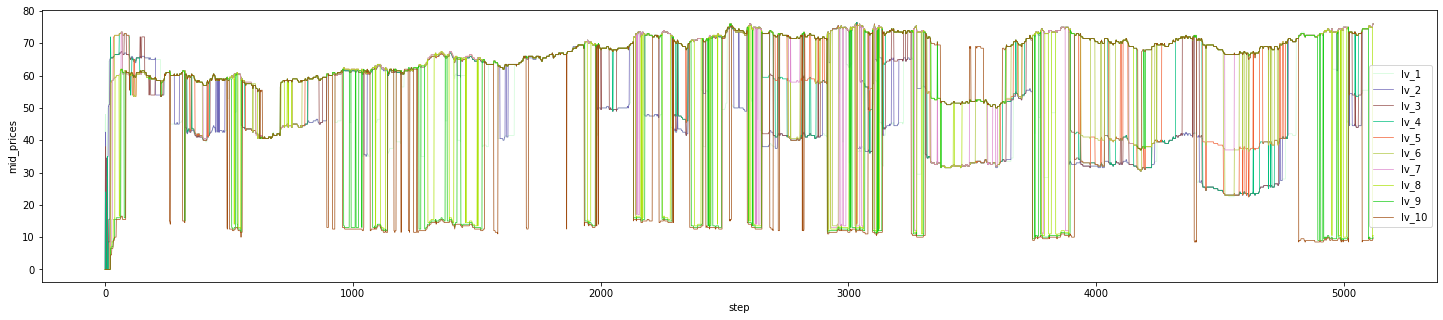

In [27]:
plot_mid_prices(mid_price_store,)

# LOB bid size

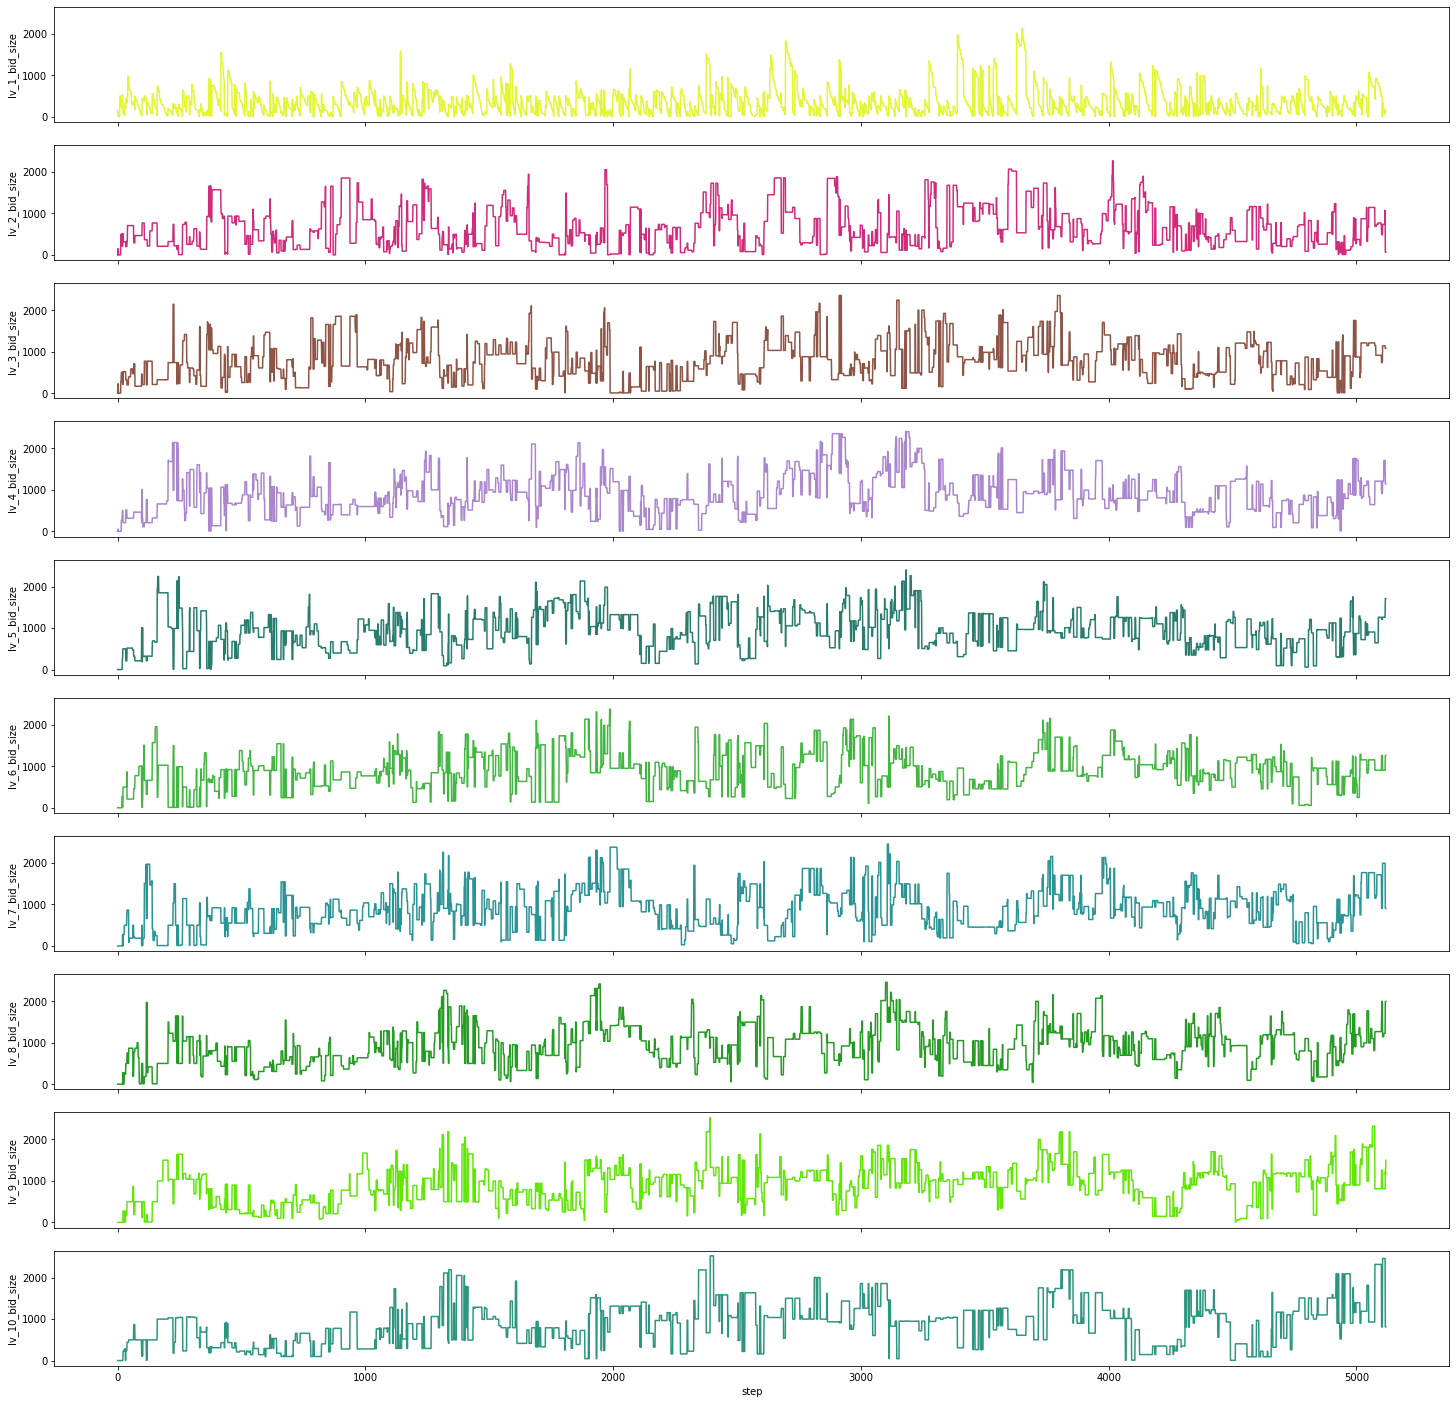

In [28]:
plot_LOB_subplot(bid_size, depth, '_bid_size')    

# LOB ask size

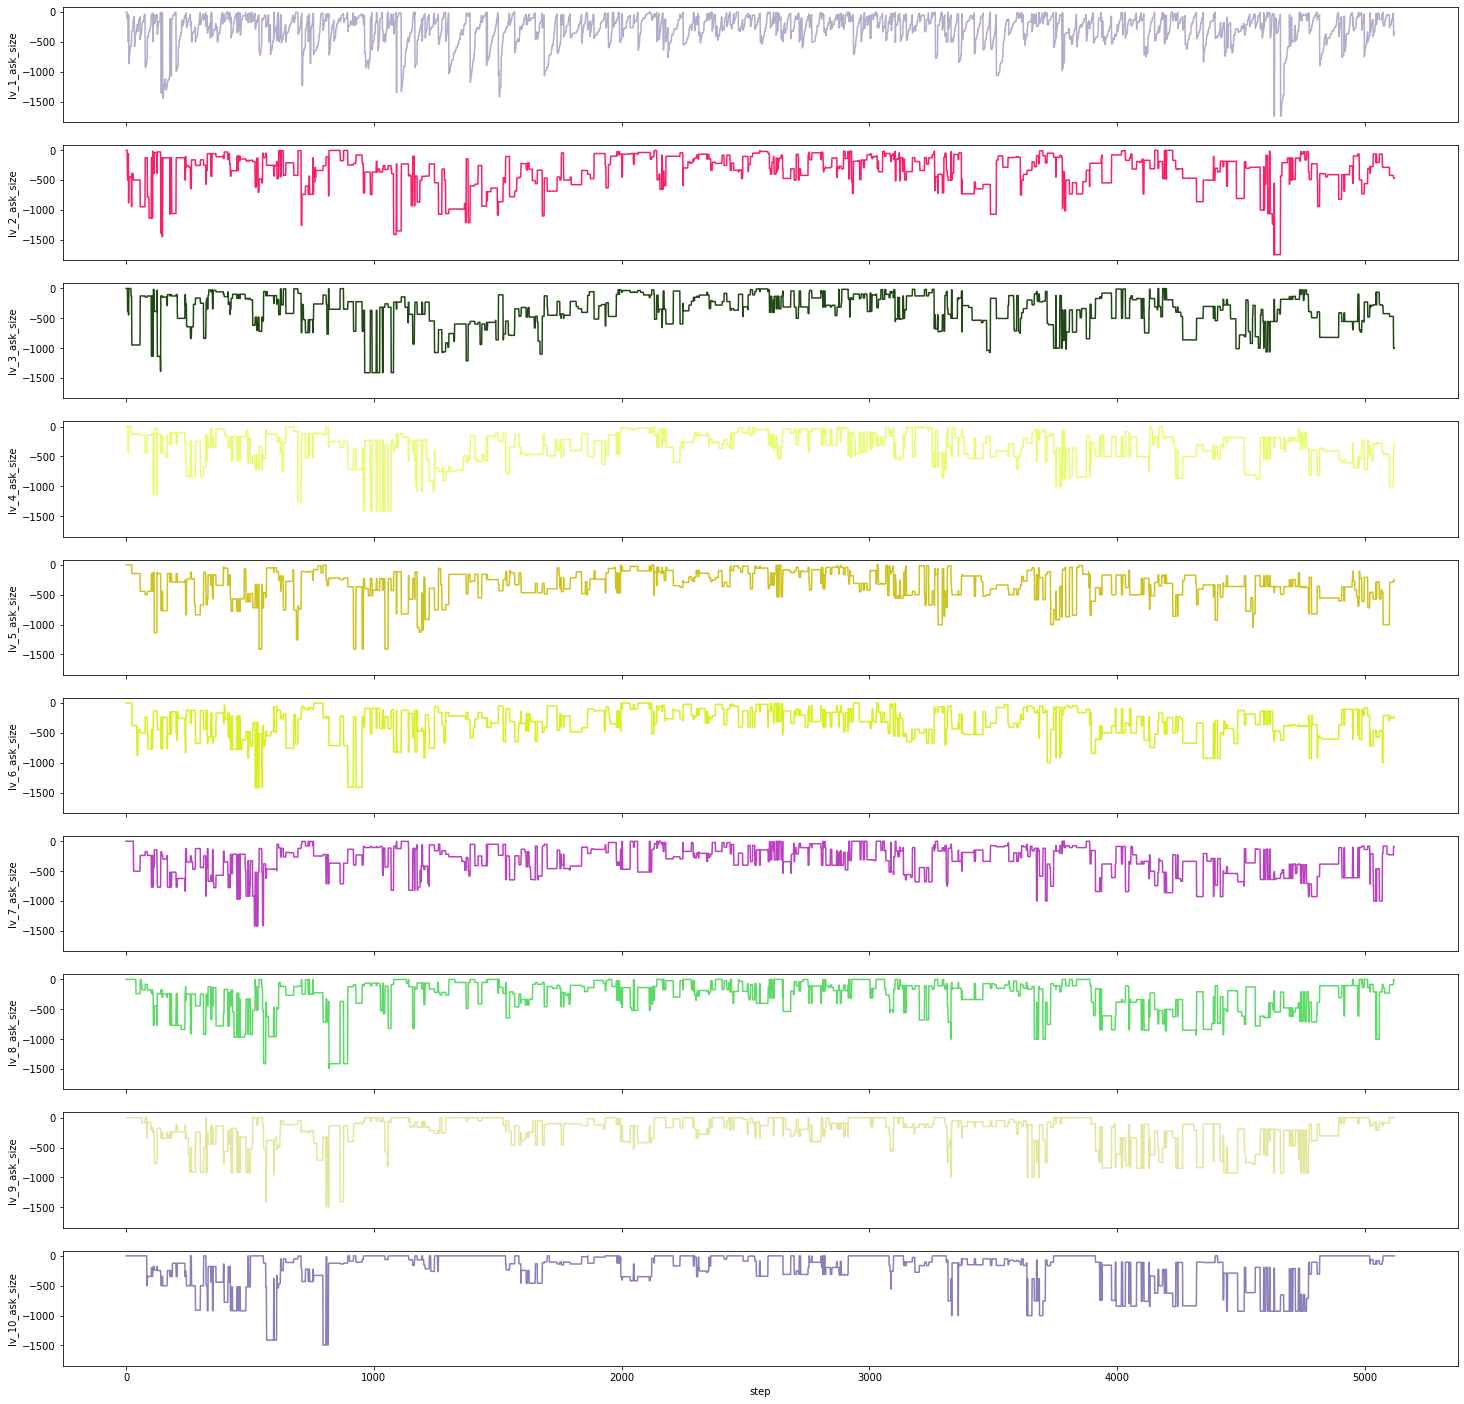

In [29]:
plot_LOB_subplot(ask_size, depth, '_ask_size')    

# LOB bid price

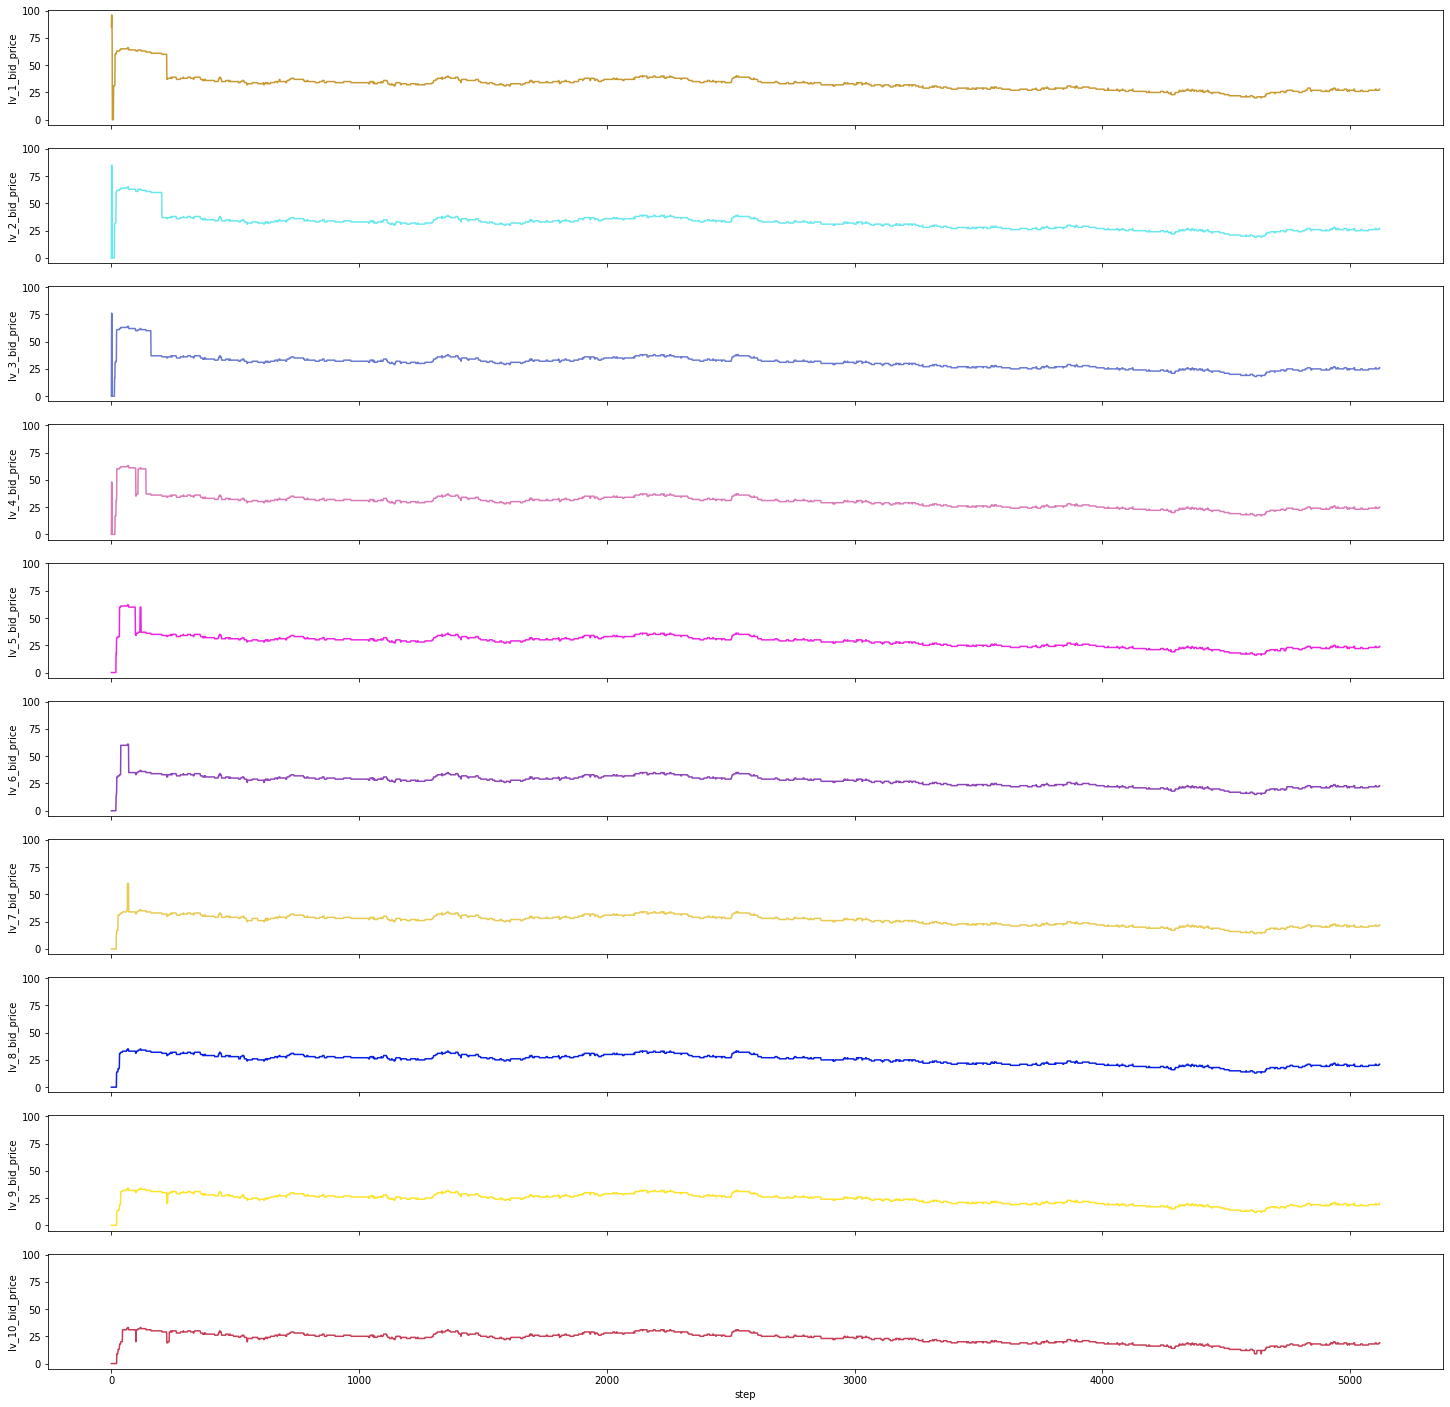

In [30]:
plot_LOB_subplot(bid_price, depth, '_bid_price')    

# LOB ask price

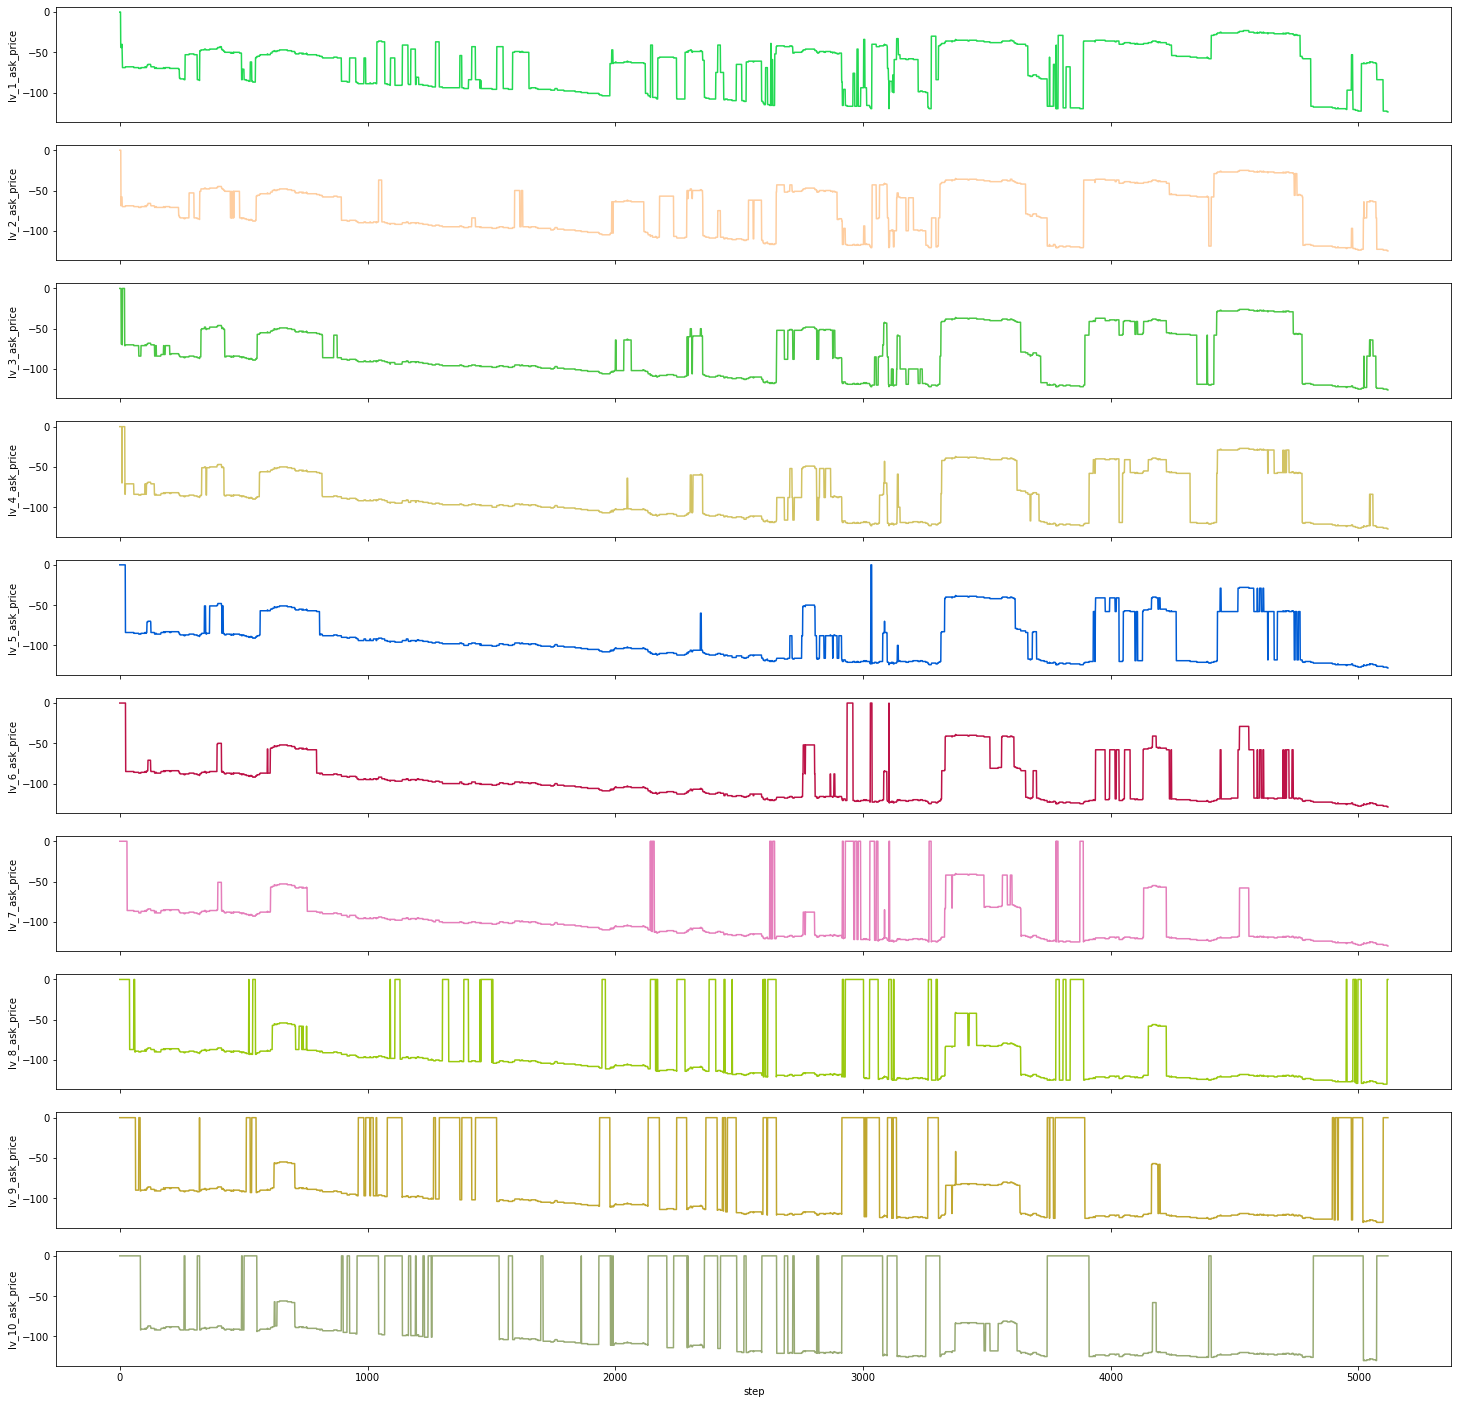

In [31]:
plot_LOB_subplot(ask_price, depth, '_ask_price')    